In [3]:
# Standard Python libraries
import pandas as pd                  # Use pandas.DataFrame to manipulate data
import matplotlib.pyplot as plt      # Standard plotting library
import warnings
warnings.filterwarnings("ignore")

# Data preprocessing
from sklearn import preprocessing    # Data preprocessing

# Model selection - split data, cv, model evaluation
from sklearn.model_selection import train_test_split    # Split dataset into training and test sets
from sklearn.model_selection import cross_val_score     # k-fold cross-validation
from sklearn.model_selection import GridSearchCV        # search for best parameters
from sklearn import metrics                             # metrics to evaluate the model performance
from sklearn.metrics import classification_report, confusion_matrix    # analyze prediction made by the classification model

# Machine learning algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif

# Feature extraction - Decomposition
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis

# Ensemble learning methods
from sklearn.ensemble import BaggingClassifier            # Bagging - (B)ootstrap (AGG)regat(ING)
from sklearn.ensemble import AdaBoostClassifier           # Boosting - (ADA)ptive (BOOST)ing
from sklearn.ensemble import VotingClassifier             # Voting

# Itertools - here, used to generate combinations of base classifiers for voting
import itertools
# Silence all war


from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [4]:
# loading train data set in dataframe from train_data.csv file
df = pd.read_csv("winequality-white.csv")
                
                

In [5]:

for i in range(len(df)):
    if df['quality'].iloc[i] == 3 or df['quality'].iloc[i] == 4  :
        df['quality'].iloc[i] = 0
    if  df['quality'].iloc[i] == 6 or df['quality'].iloc[i] == 5 :
        df['quality'].iloc[i] = 1
    if df['quality'].iloc[i] == 7 or df['quality'].iloc[i] == 8 or df['quality'].iloc[i] == 9 :
        df['quality'].iloc[i] = 2
df['quality'].value_counts()

1    3655
2    1060
0     183
Name: quality, dtype: int64

In [6]:
# Indicate the target column
target = df['quality']
# Indicate the columns that will serve as features
features = df.drop('quality', axis = 1)
features.head(1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.001,3.0,0.45,8.8


In [20]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 42)

In [21]:
scaler = StandardScaler()
features = scaler.fit_transform(features)
features[0]

array([ 0.17209696, -0.0817699 ,  0.2132802 ,  2.82134917, -0.035355  ,
        0.56993158,  0.74456503,  2.33151201, -1.24692128, -0.34918426,
       -1.39315246])

In [22]:
# Helper function #1: train and evaluate model performance.
# - The parameter `estimator` takes a list of classifier dictionary: {name, classifier}
def train_and_evaluate(estimators, X_train, X_test, Y_train, Y_test):
    # Nested function #1: Specify performance metric: only "f1_macro"
    def get_scoring_metric():
        return ['f1_macro']
    
    # Nested function #2: K-fold cross validation
    def print_validation_performance(estimator, X_train, Y_train, name=None, cv=10):
        for metric in get_scoring_metric():
            scores = cross_val_score(estimator, X_train, Y_train, cv=cv, scoring=metric)
            estimator_name = ""
            
            if name is not None:
                estimator_name = " {}".format(name)
                
            print("{} (Validation{}) = ".format(metric, estimator_name), end="")
            print("{:.4f}".format(scores.mean()))
    
    # Nested function #3: Training and testing
    def print_test_performance(estimator, X_train, X_test, Y_train, Y_test, name=None):
        estimator.fit(X_train, Y_train)
        test_predict = estimator.predict(X_test)
        dict_score = {}
        # Get performance score for each metric
        for metric in get_scoring_metric():
            estimator_name = ""
            score = 0.0
            
            if name is not None:
                estimator_name = " {}".format(name) 
            
            average = None
            acc_flag = True
            
            if "macro" in metric:
                average = "macro"
                acc_flag = False
            elif "weighted" in metric:
                average = "weighted"
                acc_flag = False
            
            print("{} (Test{}) = ".format(metric, estimator_name), end="")
            
            # Currently only supports accuracy and f1_score.
            if acc_flag:
                score = metrics.accuracy_score(Y_test, test_predict)
            else:
                score = metrics.f1_score(Y_test, test_predict, average=average)
            
            print("{:.4f}".format(score)) 
            dict_score[metric] = score
        
        print(confusion_matrix(Y_test, test_predict))         # Confusion matrix
        print(classification_report(Y_test, test_predict))    # Classification report
        
        return dict_score
    
    dict_est_score = {}
    
    # Print validation and test performance for all classifiers in the list.
    for key_est in estimators:
        print_validation_performance(estimators[key_est], X_train, Y_train, name=key_est)
        dict_est_score[key_est] = print_test_performance(estimators[key_est], 
                                                         X_train, X_test, Y_train, Y_test, 
                                                         name=key_est)
        print()
        
    return dict_est_score

# 3.Ensemble Learning


In [23]:
dict_clf_default = {
    "K-Nearest Neighbors": KNeighborsClassifier(), 
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "Linear SVM": SVC(kernel='linear', max_iter=1500), 
    "Polynomial SVM": SVC(kernel='poly', max_iter=1500), 
    "RBF SVM": SVC(kernel='rbf', max_iter=1500), 
    "Sigmoid SVM": SVC(kernel='sigmoid', max_iter=1500),
    "Logistic Regression": LogisticRegression()
    }

In [24]:
# Specify one classifier
clf_index = 1

estimator_name = list(dict_clf_default.keys())[clf_index]
estimator = {estimator_name: dict_clf_default[estimator_name]}

train_and_evaluate(estimator, x_train, x_test, y_train, y_test)

f1_macro (Validation Decision Tree) = 0.5888
f1_macro (Test Decision Tree) = 0.5960
[[ 10  18   2]
 [ 33 597  93]
 [  1  65 161]]
              precision    recall  f1-score   support

           0       0.23      0.33      0.27        30
           1       0.88      0.83      0.85       723
           2       0.63      0.71      0.67       227

    accuracy                           0.78       980
   macro avg       0.58      0.62      0.60       980
weighted avg       0.80      0.78      0.79       980




{'Decision Tree': {'f1_macro': 0.5959901455268525}}

f1_macro (Validation K-Nearest Neighbors) = 0.5114
f1_macro (Test K-Nearest Neighbors) = 0.5850
[[  6  23   1]
 [  8 661  54]
 [  0 104 123]]
              precision    recall  f1-score   support

           0       0.43      0.20      0.27        30
           1       0.84      0.91      0.87       723
           2       0.69      0.54      0.61       227

    accuracy                           0.81       980
   macro avg       0.65      0.55      0.59       980
weighted avg       0.79      0.81      0.79       980



f1_macro (Validation Decision Tree) = 0.5888
f1_macro (Test Decision Tree) = 0.5960
[[ 10  18   2]
 [ 33 597  93]
 [  1  65 161]]
              precision    recall  f1-score   support

           0       0.23      0.33      0.27        30
           1       0.88      0.83      0.85       723
           2       0.63      0.71      0.67       227

    accuracy                           0.78       980
   macro avg       0.58      0.62      0.60       980
weighted avg       

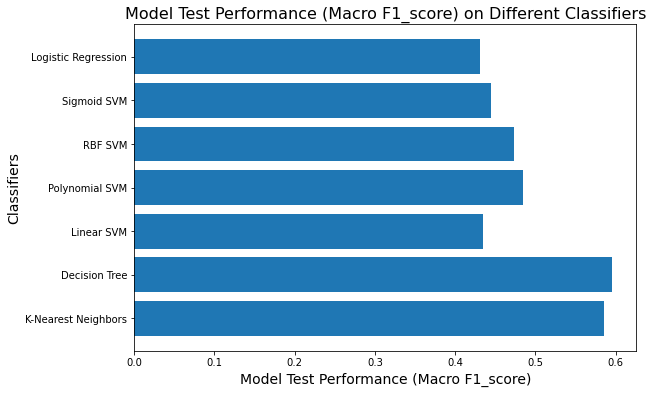

,classifier_0,classifier_1,classifier_2,classifier_3,classifier_4,classifier_5,classifier_6,test_performance
0,K-Nearest Neighbors,Decision Tree,Linear SVM,Polynomial SVM,RBF SVM,Sigmoid SVM,Logistic Regression,0.585017
1,K-Nearest Neighbors,Decision Tree,Linear SVM,Polynomial SVM,RBF SVM,Sigmoid SVM,Logistic Regression,0.595990
2,K-Nearest Neighbors,Decision Tree,Linear SVM,Polynomial SVM,RBF SVM,Sigmoid SVM,Logistic Regression,0.434019
3,K-Nearest Neighbors,Decision Tree,Linear SVM,Polynomial SVM,RBF SVM,Sigmoid SVM,Logistic Regression,0.484193
4,K-Nearest Neighbors,Decision Tree,Linear SVM,Polynomial SVM,RBF SVM,Sigmoid SVM,Logistic Regression,0.473528
5,K-Nearest Neighbors,Decision Tree,Linear SVM,Polynomial SVM,RBF SVM,Sigmoid SVM,Logistic Regression,0.445033
6,K-Nearest Neighbors,Decision Tree,Linear SVM,Polynomial SVM,RBF SVM,Sigmoid SVM,Logistic Regression,0.431404


In [25]:

# Baseline - compare all classifiers
list_clf = []
list_score = []

score_param = "f1_score"
average_param = "macro"

# Generating results
# ---
# Iterate through all classifiers
for clf in dict_clf_default:
    estimator = { clf: dict_clf_default[clf] }
    try:
        score = train_and_evaluate(estimator, x_train, x_test, y_train, y_test)
        
    except Exception as e:
        error_class_name = e.__class__.__name__
        print("{}: {}\n".format(error_class_name, e))
        continue
        
    print()
    
    list_clf.append(clf)
    list_score = list_score + list(score[clf].values())

    
# Create data frame
# ---
data = dict(classifier=list_clf, test_performance=list_score)
df_performance = pd.DataFrame(data=data)

# # Save and export df_performance to CSV file (optional)
# df_performance.to_csv(r'final_project_performance_default.csv', index = False, hea

# Plotting
# ---
str_x_label = "Model Test Performance ({} {})".format(average_param.capitalize(), score_param.capitalize())
font_size = 12

plt.figure(figsize=(9, 6))
plt.barh(list_clf, list_score)

plt.title("{} on Different Classifiers".format(str_x_label), fontsize=(font_size + 4))
plt.xlabel(str_x_label, fontsize=(font_size + 2))
plt.ylabel("Classifiers", fontsize=(font_size + 2))

plt.show()
# Create data frame
# ---
data = dict()
for i, base_clf in enumerate(list_clf):
    clf_key = "classifier_{}".format(i)
    data[clf_key] = base_clf

data["test_performance"] = list_score
df_performance = pd.DataFrame(data=data)

# Save and export df_performance to CSV file (optional)
df_performance.to_csv(r'final_project_performance_baseline_{}clf.csv'.format(3), index = False, header = True)

df_performance

# # Save plot into PNG (optional) 
# plt.savefig("final_project_performance_default.png", dpi=300, bbox_inches="tight")

# 3.1Bagging

In [26]:
# Specify classifier
clf_index = 1    # Accepts value from 0 - 6

# Define parameter values for BaggingClassifier object
base = list(dict_clf_default.values())[clf_index]
bagging_param = dict(base_estimator=base,
                     n_estimators=100,    # create 100 different models using the same `base_estimator`
                     random_state=0)

# Define BaggingClassifier object
model_bagging = BaggingClassifier(**bagging_param)

estimator_name = "Bagging - {}".format(list(dict_clf_default.keys())[clf_index])
estimator = {estimator_name: model_bagging}

# Train and evaluate the performance of the bagging classifier
train_and_evaluate(estimator, x_train, x_test, y_train, y_test)

f1_macro (Validation Bagging - Decision Tree) = 0.6274
f1_macro (Test Bagging - Decision Tree) = 0.6428
[[  6  24   0]
 [  6 684  33]
 [  0  76 151]]
              precision    recall  f1-score   support

           0       0.50      0.20      0.29        30
           1       0.87      0.95      0.91       723
           2       0.82      0.67      0.73       227

    accuracy                           0.86       980
   macro avg       0.73      0.60      0.64       980
weighted avg       0.85      0.86      0.85       980




{'Bagging - Decision Tree': {'f1_macro': 0.6427570807132851}}

In [ ]:
# Bagging - compare all classifiers
list_clf = []
list_score = []

score_param = "f1_score"
average_param = "macro"

bagging_param = dict(n_estimators=100, random_state=0)


# Generate results
# ---
# Iterate through all classifiers
for i, clf in enumerate(dict_clf_default):
    base = dict_clf_default[clf]
    
    params = bagging_param.copy()
    params["base_estimator"] = base

    model_bagging = BaggingClassifier(**params)
    
    estimator = { clf: model_bagging }
    
    try:
        score = train_and_evaluate(estimator, x_train, x_test, y_train, y_test)
        
    except Exception as e:
        error_class_name = e.__class__.__name__
        print("{}: {}\n".format(error_class_name, e))
        continue
    
    print()
    
    list_clf.append(clf)
    list_score = list_score + list(score[clf].values())
    # Create data frame
# ---
data = dict(classifier=list_clf, test_performance=list_score)
df_performance = pd.DataFrame(data=data)

# # Save and export df_performance to CSV file (optional)
# df_performance.to_csv(r'final_project_performance_bagging.csv', index = False, header = True)


# Plotting
# ---
str_x_label = "Model Test Performance ({} {})".format(average_param.capitalize(), score_param.capitalize())
font_size = 12

plt.figure(figsize=(9, 6))
plt.barh(list_clf, list_score)

plt.title("Bagging: {} on Different Base Classifiers".format(str_x_label), fontsize=(font_size + 4))
plt.xlabel(str_x_label, fontsize=(font_size + 2))
plt.ylabel("Base Classifiers", fontsize=(font_size + 2))

plt.show()






# Create data frame
# ---
data = dict()
for i, base_clf in enumerate(list_clf):
    clf_key = "classifier_{}".format(i)
    data[clf_key] = base_clf

data["test_performance"] = list_score
df_performance = pd.DataFrame(data=data)

# Save and export df_performance to CSV file (optional)
df_performance.to_csv(r'final_project_performance_bagging_{}clf.csv'.format(3), index = False, header = True)

df_performance
# # Save plot into PNG (optional) 
# plt.savefig("final_project_performance_bagging.png", dpi=300, bbox_inches="tight")

f1_macro (Validation K-Nearest Neighbors) = 0.5153
f1_macro (Test K-Nearest Neighbors) = 0.5778
[[  5  24   1]
 [  3 661  59]
 [  0 105 122]]
              precision    recall  f1-score   support

           0       0.62      0.17      0.26        30
           1       0.84      0.91      0.87       723
           2       0.67      0.54      0.60       227

    accuracy                           0.80       980
   macro avg       0.71      0.54      0.58       980
weighted avg       0.79      0.80      0.79       980



f1_macro (Validation Decision Tree) = 0.6274
f1_macro (Test Decision Tree) = 0.6428
[[  6  24   0]
 [  6 684  33]
 [  0  76 151]]
              precision    recall  f1-score   support

           0       0.50      0.20      0.29        30
           1       0.87      0.95      0.91       723
           2       0.82      0.67      0.73       227

    accuracy                           0.86       980
   macro avg       0.73      0.60      0.64       980
weighted avg       

In [ ]:
scaler = StandardScaler()
features = scaler.fit_transform(features)
features[0]


# 3.2 boosting


In [ ]:

_ = [print("Index: {} - {}".format(i, clf)) for i, clf in enumerate(dict_clf_default)]

In [ ]:
# Specify one classifier
clf_index = 1    # Accepts value from 0 - 6

# Define parameter values for AdaBoostClassifier object
base = list(dict_clf_default.values())[clf_index]
boosting_param = dict(base_estimator=base,
                     n_estimators=100,
                     random_state=0)

# Define AdaBoostClassifier object
model_boosting = AdaBoostClassifier(**boosting_param)

estimator_name = "Boosting - {}".format(list(dict_clf_default.keys())[clf_index])
estimator = {estimator_name: model_boosting}

# Train and evaluate the performance of the AdaBoost classifier
train_and_evaluate(estimator, x_train, x_test, y_train, y_test)


In [ ]:
# SVM Boosting 
clf_index = 2    # Accepts value from 0 - 6

# Define parameter values for AdaBoostClassifier object
base = list(dict_clf_default.values())[clf_index]
boosting_param = dict(base_estimator=base,
                     n_estimators=100,
                     algorithm='SAMME',random_state=0)

# Define AdaBoostClassifier object
model_boosting = AdaBoostClassifier(**boosting_param)
#model_boosting = AdaBoostClassifier((svm.SVC(probability=True,kernel='linear'),n_estimators=50,learning_rate=1.0,algorithm='SAMME')

estimator_name = "Boosting - {}".format(list(dict_clf_default.keys())[clf_index])
estimator = {estimator_name: model_boosting}

# Train and evaluate the performance of the AdaBoost classifier
train_and_evaluate(estimator, x_train, x_test, y_train, y_test)

In [ ]:
# Compare all classifiers
list_clf = []
list_score = []

score_param = "f1_score"
average_param = "macro"

feature_train = x_train
feature_test = x_test

# Initialize parameter values of boosting classifier
boosting_param = dict(n_estimators=100,random_state=0)

# Loop through all classifiers
# ---
for i, clf in enumerate(dict_clf_default):
    print("- {}".format(clf))
    base = dict_clf_default[clf]
    
    if i<1:
        params = boosting_param.copy()
    else:
        params = dict(n_estimators=100,algorithm='SAMME',random_state=0)
    
    params["base_estimator"] = base
    
    
    estimator = { clf: model_boosting }
    
    try:
        score = train_and_evaluate(estimator, x_train, x_test, y_train, y_test)
    
    except Exception as e:
        error_class_name = e.__class__.__name__
        print("{}: {}\n".format(error_class_name, e))
        continue
    
    print()
    
    list_clf.append(clf)
    list_score = list_score + list(score[clf].values())
    # Create data frame
# ---
data = dict(classifier=list_clf, test_performance=list_score)
df_performance = pd.DataFrame(data=data)

# # Save and export df_performance to CSV file
# df_performance.to_csv(r'final_project_performance_boosting.csv', index = False, header = True)

# Plotting
# ---
str_x_label = "Model Test Performance ({} {})".format(average_param.capitalize(), score_param.capitalize())
font_size = 12

plt.figure(figsize=(9, 6))
plt.barh(list_clf, list_score)

plt.title("Boosting: {} on Different Base Classifiers".format(str_x_label), fontsize=(font_size + 4))
plt.xlabel(str_x_label, fontsize=(font_size + 2))
plt.ylabel("Base Classifiers", fontsize=(font_size + 2))

plt.show()

##Save plot into PNG (optional) 
##plt.savefig("final_project_performance_boosting.png", dpi=300, bbox_inches="tight")
# Create data frame
# ---
data = dict()
for i, base_clf in enumerate(list_clf):
    clf_key = "classifier_{}".format(i)
    data[clf_key] = base_clf

data["test_performance"] = list_score
df_performance = pd.DataFrame(data=data)

# Save and export df_performance to CSV file (optional)
df_performance.to_csv(r'final_project_performance_boosting_{}clf.csv'.format(3), index = False, header = True)

df_performance
    

# 3.3 Voting

In [ ]:
score_param = "f1_score"
average_param = "macro"

# specify number of base classifiers
num_base_clf = 3                                # Accepts values from 2 - 4 (number of base classifiers)
list_clf = [[] for i in range(num_base_clf)]    # 2-dimensional list, to store list of classifiers in
                                                # each voting classifier
list_score = []

# Generate all possible combinations of base classifiers with # of classifiers = num_base_clf
# ---
# For example: if num_base_clf = 3, 
# [A, B, C, D] -> [A, B, C], [A, B, D], [A, C, D] and [B, C, D]
combinations_base_clf = itertools.combinations(dict_clf_default, num_base_clf)

# Iterate through all generated lists
for comb in combinations_base_clf:
    list_base_clf = []
    
    # Return number of SVM classifiers in a list
    count_svm = sum("SVM" in clf for clf in comb)    
    
    # At most one SVM classifier in the list.
    # - skip all the lists with >1 classifiers - speed up iteration
    # - ensure variation in machine learning algorithms in the voting classifier
    if count_svm <= 1:
        for i, clf in enumerate(comb):
            list_base_clf.append((clf, dict_clf_default[clf]))
            list_clf[i].append(clf)
    
        print(comb)
        print("---")
        
        try:
            model_voting = VotingClassifier(estimators=list_base_clf)
            estimator_name = "Voting Classifier"
            estimator = { estimator_name : model_voting }
            score = train_and_evaluate(estimator, x_train, x_test, y_train, y_test)
            
            list_score = list_score + list(score[estimator_name].values())
            
        except Exception as e:
            error_class_name = e.__class__.__name__
            print("{}: {}\n".format(error_class_name, e))
            continue
        
        print()

        
# Create data frame
# ---
data = dict()
for i, base_clf in enumerate(list_clf):
    clf_key = "classifier_{}".format(i)
    data[clf_key] = base_clf

data["test_performance"] = list_score
df_performance = pd.DataFrame(data=data)

# Save and export df_performance to CSV file (optional)
df_performance.to_csv(r'final_project_performance_voting_{}clf.csv'.format(3), index = False, header = True)

df_performance
            

In [ ]:
# voting 继承学习
from sklearn.ensemble import RandomForestClassifier
clf_index = 1    # Accepts value from 0 - 6

log = LogisticRegression()
rnd = RandomForestClassifier()
svm = SVC()


# Define VotingClassifier object
model_boosting = VotingClassifier(estimators=[('lr',log), ('rf',rnd), ('svm',svm)],voting='hard')

estimator_name = "Voting - {}".format(list(dict_clf_default.keys())[clf_index])
estimator = {estimator_name: model_boosting}

# Train and evaluate the performance of the Voting classifier
train_and_evaluate(estimator, x_train, x_test, y_train, y_test)


In [ ]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

# 3.4 stacking

# Stacking-single

In [ ]:
# Define StackingClassifier object
estimators = [ ('rf', RandomForestClassifier(random_state=42)),
             ('nk',KNeighborsClassifier())]

model_boosting = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

estimator_name = "Stacking - {}".format(list(dict_clf_default.keys())[clf_index])
estimator = {estimator_name: model_boosting}

# Train and evaluate the performance of the Voting classifier
train_and_evaluate(estimator, x_train, x_test, y_train, y_test)


In [ ]:
dict_clf_default = {
    "K-Nearest Neighbors": KNeighborsClassifier(), 
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "Linear SVM": SVC(kernel='linear', max_iter=1500), 
    "Polynomial SVM": SVC(kernel='poly', max_iter=1500), 
    "RBF SVM": SVC(kernel='rbf', max_iter=1500), 
    "Sigmoid SVM": SVC(kernel='sigmoid', max_iter=1500),
    "Logistic Regression": LogisticRegression()
    }

# Stacking- three random group

In [ ]:
score_param = "f1_score"
average_param = "macro"

# specify number of base classifiers
num_base_clf = 3                                # Accepts values from 2 - 4 (number of base classifiers)
list_clf = [[] for i in range(num_base_clf)]    # 2-dimensional list, to store list of classifiers in
                                                # each voting classifier
list_score = []

# For example: if num_base_clf = 3, 
# [A, B, C, D] -> [A, B, C], [A, B, D], [A, C, D] and [B, C, D]
combinations_base_clf = itertools.combinations(dict_clf_default, num_base_clf)

nameList=[]
listAll=[]
for comb in combinations_base_clf:
    nameList.append(comb)
    list1=[]
    for name in comb:
       
        list1.append((name, dict_clf_default.get(name)))
    listAll.append(list1)

# Iterate through all generated lists
i=0
for comb in listAll:
    print(nameList[i])
    print("---")
    i+=1
    try:
        model_voting = StackingClassifier(estimators=comb, final_estimator=LogisticRegression())
        estimator_name = "Stacking Classifier"
        estimator = { estimator_name : model_voting }
        score = train_and_evaluate(estimator, x_train, x_test, y_train, y_test)

        list_score = list_score + list(score[estimator_name].values())

    except Exception as e:
        error_class_name = e.__class__.__name__
        print("{}: {}\n".format(error_class_name, e))
        continue

    print("------------------------------------------------------------------------------")

        


In [ ]:
# Create data frame
# ---
for comb in nameList:
    for i, clf in enumerate(comb):
                list_base_clf.append((clf, dict_clf_default[clf]))
                list_clf[i].append(clf)

            
data = dict()
for i, base_clf in enumerate(list_clf):
    clf_key = "classifier_{}".format(i)
    data[clf_key] = base_clf

data["test_performance"] = list_score
df_performance1 = pd.DataFrame(data=data)

# Save and export df_performance to CSV file (optional)
df_performance1.to_csv(r'final_project_performance_stacking_{}clf.csv'.format(3), index = False, header = True)

df_performance1
            